<a href="https://colab.research.google.com/github/Lenguist/insight-game-ai/blob/main/simple_sim_united.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description moved to readme

# Simulation code (only know # of turns)


In [1]:
from simulations import basic_simulation
from sellers import RandomSeller
from sellers import DescentArithmeticSeller
imp_list = [i / 10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 10000
init_offer=range_max

# random agent
random_results = []
seller = RandomSeller(value=value, init_offer=init_offer)
for imp_incr in imp_list:
  result = basic_simulation(value,
                        range_min,
                        range_max,
                        imp_incr = imp_incr,
                        imp_init = 0,
                        rounds = rounds,
                        seller=seller)
  random_results.append(result)

# simple heuristic agent, consistently performs better than random
arithmetic_results = []
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
for imp_incr in imp_list:
  result = basic_simulation(value,
                        range_min,
                        range_max,
                        imp_incr = imp_incr,
                        imp_init = 0,
                        rounds = rounds,
                        seller=seller)
  arithmetic_results.append(result)

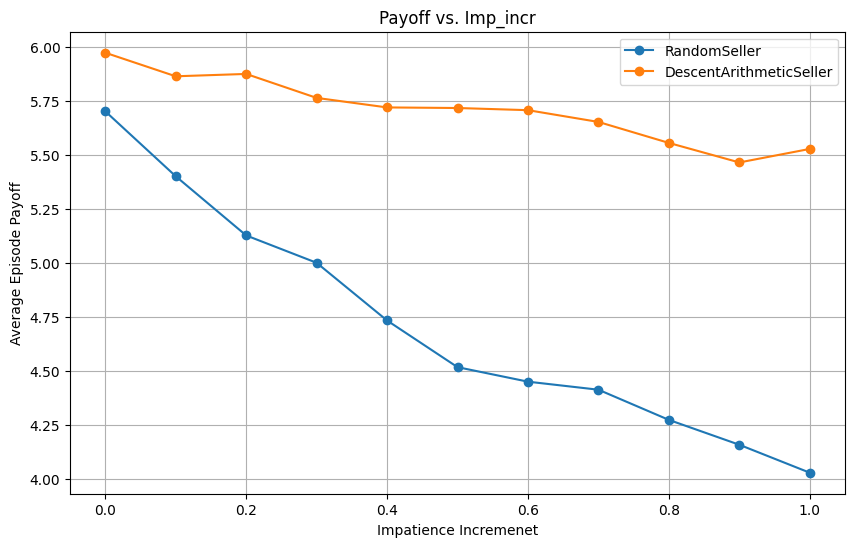

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(imp_list, random_results, marker='o', label=f'RandomSeller')
plt.plot(imp_list, arithmetic_results, marker='o', label=f'DescentArithmeticSeller')
plt.title('Payoff vs. Imp_incr')
plt.xlabel('Impatience Incremenet')
plt.ylabel('Average Episode Payoff')
plt.grid()

plt.legend()  # This will create a legend using the labels specified in the plot functions

plt.show()

In [3]:
from simulations import *
imp_list = [i / 10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 10000
init_offer=range_max

# random agent
seller = RandomSeller(value=value, init_offer=init_offer)
random_results = random_imp_simulation(value,
                        range_min,
                        range_max,
                        rounds = rounds,
                        seller=seller)

# simple heuristic agent, consistently performs better than random
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
arithmetic_results = random_imp_simulation(value,
                        range_min,
                        range_max,
                        rounds = rounds,
                        seller=seller)

In [ ]:
# random agent random impatience results
random_results

In [ ]:
# arithmetic agent random impatience result
arithmetic_results

In [ ]:
mean_list = [i/10.0 for i in range(11)]
all_results = []

# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30
rounds = 100000
init_offer=range_max

# random agent
random_results = []
seller = RandomSeller(value=value, init_offer=init_offer)
for mean in mean_list:
  result = normal_imp_simulation(value,
                        range_min,
                        range_max,
                        mean = mean,
                        rounds = rounds,
                        seller=seller)
  random_results.append(result)

# simple heuristic agent, consistently performs better than random
arithmetic_results = []
n = int((init_offer-value)/2)
seller = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
for mean in mean_list:
  result = normal_imp_simulation(value,
                        range_min,
                        range_max,
                        mean = mean,
                        rounds = rounds,
                        seller=seller)
  arithmetic_results.append(result)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(mean_list, random_results, marker='o', label=f'RandomSeller')
plt.plot(mean_list, arithmetic_results, marker='o', label=f'DescentArithmeticSeller')
plt.title('Payoff vs. Imp_incr')
plt.xlabel('Mean Impatience Incremenet')
plt.ylabel('Average Episode Payoff')
plt.grid()

plt.legend()  # This will create a legend using the labels specified in the plot functions

plt.show()

# Two sellers

In [4]:
from sellers import *

In [6]:
# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30

n = int((init_offer-value)/2)

seller1 = RandomSeller(value=value, init_offer=init_offer)
seller2 = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
seller1_total_profit = 0
seller2_total_profit = 0
rounds = 5
for i in range(rounds):
  imp_init = 0
  imp_incr = random.choice([i / 10.0 for i in range(11)])
  maxprice = int(random.uniform(range_min, range_max+1))
  buyer = Buyer(maxprice, imp_init, imp_incr)
  episode1 = Episode(buyer, seller1, verbose=True)
  episode2 = Episode(buyer, seller2, verbose=True)
  print("RandomSeller")
  seller1_profit = episode1.run_episode()
  print("HeuristicSeller")
  seller2_profit = episode2.run_episode()
  print("\n")
  seller1_total_profit += seller1_profit
  seller2_total_profit += seller2_total_profit

RandomSeller
Curr state: {'last-offer': 30, 'offers-made': 0}
Seller made offer of 21. The buyer decided to accept offer
Deal made at 21
Buyer's max_price was 26
HeuristicSeller
Curr state: {'last-offer': 30, 'offers-made': 0}
Seller made offer of 20. The buyer decided to accept offer
Deal made at 20
Buyer's max_price was 26


RandomSeller
Curr state: {'last-offer': 30, 'offers-made': 0}
Seller made offer of 21. The buyer decided to accept offer
Deal made at 21
Buyer's max_price was 27
HeuristicSeller
Curr state: {'last-offer': 30, 'offers-made': 0}
Seller made offer of 20. The buyer decided to accept offer
Deal made at 20
Buyer's max_price was 27


RandomSeller
Curr state: {'last-offer': 30, 'offers-made': 0}
Seller made offer of 29. The buyer decided to reject but continue
Curr state: {'last-offer': 29, 'offers-made': 1}
Seller made offer of 22. The buyer decided to reject but continue
Curr state: {'last-offer': 22, 'offers-made': 2}
Seller made offer of 15. The buyer decided to acce

In [33]:
import random

# this seller looks at all buyers before making decision!
class EducatedBuyer(object):
    def __init__(self, maxprice, imp_incr):
        self.maxprice = maxprice
        self.imp = 0
        self.imp_incr = imp_incr
    def check_all_offers(self, offers):
      decisions = [] # saves decision for each offer

      # walks away from all offers if impatient
      random_number = random.uniform(0, 1)
      if random_number <= self.imp:
        decisions = ["walk away" for decision in decisions]
      print(len(offers))
      
      for offer in offers:
        print("hello")
        if offer <= self.maxprice:
          decisions.append("accept offer")
        else:
          decisions.append("reject but continue")


        self.imp += self.imp_incr
        return decisions

In [36]:
edubuyer = EducatedBuyer(15, 0.1)
edubuyer.check_all_offers([12,20,14])

3
Hello


[]

In [37]:
import random

class EducatedBuyer(object):
    def __init__(self, max_price, imp_incr):
        self.max_price = max_price
        self.imp = 0
        self.imp_incr = imp_incr

    def check_all_offers(self, offers):
        decisions = [] # saves decision for each offer
        accept_indices = [] # saves indices of accepted offers
        accept_values = [] # saves values of accepted offers

        random_number = random.uniform(0, 1)
        if random_number <= self.imp:
            decisions = ["walk away" for decision in decisions]
        else:
            for i, offer in enumerate(offers):
                if offer <= self.max_price:
                    decisions.append("accept offer")
                    accept_indices.append(i)
                    accept_values.append(offer)
                else: 
                    decisions.append("reject but continue")

        # if more than one offer is accepted
        if len(accept_indices) > 1:
            min_value = min(accept_values)
            min_indices = [i for i, value in zip(accept_indices, accept_values) if value == min_value]

            if len(min_indices) > 1:
                # randomly choose an offer to accept if there are multiple offers with the minimum value
                accept_index = random.choice(min_indices)
            else:
                # if there is a unique minimum, accept it
                accept_index = min_indices[0]
            for idx in accept_indices:
              if idx == accept_index:
                decisions[idx] = "accept offer"
              else:
                decisions[idx] = "competitor won"

        self.imp += self.imp_incr
        return decisions


In [38]:
edubuyer = EducatedBuyer(15, 0.1)
edubuyer.check_all_offers([12,20,14])

['accept offer', 'reject but continue', 'competitor won']

In [7]:
class Episode(object):
  def __init__(self, buyer, seller1, seller2, verbose=True):
    self.buyer = buyer
    self.seller1 = seller1
    self.seller2 = seller2
    self.verbose = verbose # whether to print info

  def negotiation_round(self):
    if self.verbose:
      print(f"Curr state of seller1: {self.seller1.state}")
      print(f"Curr state of seller2: {self.seller2.state}")

    offer1 = self.seller1.make_offer()
    offer2 = self.seller2.make_offer()
    decision1 = self.buyer.check_offer(offer1)
    decision2 = self.buyer.check_offer(offer2)
    new_state1 = {"last-offer":offer1, "offers-made":self.seller1.state["offers-made"]+1}
    new_state2 = {"last-offer":offer2, "offers-made":self.seller2.state["offers-made"]+1}
    self.seller.state1 = new_state1

    if self.verbose:
      print(f"Seller1 made offer of {offer1}. The buyer decided to {decision1}")
      print(f"Seller1 made offer of {offer1}. The buyer decided to {decision1}")
    return decision1, decision2

  def run_episode(self):
    decision = ""
    decision1 == "accept offer"
    while decision != "walk away" and decision != "accept offer":
      decision = self.negotiation_round()

    if decision == "accept offer":
      final_offer = self.seller.state["last-offer"]
      profit = final_offer - self.seller.value
      if self.verbose:
        print(f"Deal made at {final_offer}")
        print(f"Buyer's max_price was {self.buyer.maxprice}")

    else:
      if self.verbose:
        print(f"No deal made - no profit.")
        print(f"Buyer's max_price was {self.buyer.maxprice}")
      profit = 0
    # reset seller state
    self.seller.reset_state()
    return profit

SyntaxError: invalid syntax (68891768.py, line 28)

In [ ]:
# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 30

n = int((init_offer-value)/2)

seller1 = RandomSeller(value=value, init_offer=init_offer)
seller2 = DescentArithmeticSeller(value=value, init_offer=init_offer, init_descent = n)
seller1_total_profit = 0
seller2_total_profit = 0
rounds = 5
for i in range(rounds):
  imp_init = 0
  imp_incr = random.choice([i / 10.0 for i in range(11)])
  maxprice = int(random.uniform(range_min, range_max+1))
  buyer = Buyer(maxprice, imp_init, imp_incr)
  episode1 = Episode(buyer, seller1, verbose=True)
  episode2 = Episode(buyer, seller2, verbose=True)
  print("RandomSeller")
  seller1_profit = episode1.run_episode()
  print("HeuristicSeller")
  seller2_profit = episode2.run_episode()
  print("\n")
  seller1_total_profit += seller1_profit
  seller2_total_profit += seller2_total_profit